# Capstone Project
## Image classifier for the SVHN dataset
### Instructions

In this notebook, you will create a neural network that classifies real-world images digits. You will use concepts from throughout this course in building, training, testing, validating and saving your Tensorflow classifier model.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (File -> Download as -> PDF via LaTeX). You should then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [2]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

![SVHN overview image](data/svhn_examples.jpg)
For the capstone project, you will use the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This is an  image dataset of over 600,000 digit images in all, and is a harder dataset than MNIST as the numbers appear in the context of natural scene images. SVHN is obtained from house numbers in Google Street View images. 

* Y. Netzer, T. Wang, A. Coates, A. Bissacco, B. Wu and A. Y. Ng. "Reading Digits in Natural Images with Unsupervised Feature Learning". NIPS Workshop on Deep Learning and Unsupervised Feature Learning, 2011.

Your goal is to develop an end-to-end workflow for building, training, validating, evaluating and saving a neural network that classifies a real-world image into one of ten classes.

In [3]:
# Run this cell to load the dataset
train = loadmat('data/train_32x32.mat')
test = loadmat('data/test_32x32.mat')

Both `train` and `test` are dictionaries with keys `X` and `y` for the input images and labels respectively.

## 1. Inspect and preprocess the dataset
* Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
* Select a random sample of images and corresponding labels from the dataset (at least 10), and display them in a figure.
* Convert the training and test images to grayscale by taking the average across all colour channels for each pixel. _Hint: retain the channel dimension, which will now have size 1._
* Select a random sample of the grayscale images and corresponding labels from the dataset (at least 10), and display them in a figure.

In [4]:
#Extract the training and testing images and labels separately from the train and test dictionaries loaded for you.
X_train = train['X']
X_test = test['X']
y_train = train['y']
y_test = test['y']

In [5]:
X_train.shape

(32, 32, 3, 73257)

In [6]:
#Converting array of shape (32,32,3,Batch) into shape (Batch,32,32,3)
X_train = np.moveaxis(X_train, -1, 0)
X_test = np.moveaxis(X_test, -1, 0)

In [7]:
X_train.shape

(73257, 32, 32, 3)

In [8]:
y_train = np.where(y_train==10, 0, y_train)
y_test = np.where(y_test==10, 0, y_test)

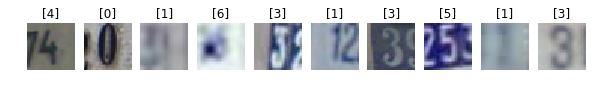

In [9]:
indices = random.sample( range(0,X_train.shape[0]), 10 )
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[indices[i]])
    ax[i].set_title(y_train[indices[i]])

In [10]:
X_train_greyscale = np.mean(X_train, -1, keepdims=True)
X_test_greyscale = np.mean(X_test, -1, keepdims=True)

In [11]:
print(X_train_greyscale[2].sum())
print(X_train[2].sum())


190026.0
570078


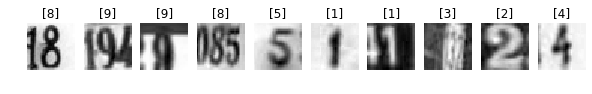

In [12]:
indices = random.sample( range(0,X_train_greyscale.shape[0]), 10 )
fig, ax = plt.subplots(1, 10, figsize=(10,1))

for i in range(10):
    ax[i].set_axis_off()
    ax[i].imshow(X_train_greyscale[indices[i],:,:,0], cmap='gray')
    ax[i].set_title(y_train[indices[i]])

## 2. MLP neural network classifier
* Build an MLP classifier model using the Sequential API. Your model should use only Flatten and Dense layers, with the final layer having a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different MLP architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 4 or 5 layers._
* Print out the model summary (using the summary() method)
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run. 
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* As a guide, you should aim to achieve a final categorical cross entropy training loss of less than 1.0 (the validation loss might be higher).
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [28]:
def get_new_MLP_model():
    
    Model = Sequential([
        Flatten(input_shape=X_train[0].shape),
        Dense(512, activation='relu'),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
    return Model

model = get_new_MLP_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_10 (Dense)             (None, 10)                1290      
Total params: 2,001,546
Trainable params: 2,001,546
Non-trainable params: 0
____________________________________________

In [28]:
cp_path = 'Checkpoint/Best_model'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [29]:
EarlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [31]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [34]:
history = model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1, validation_split=0.1, callbacks=[cp, EarlyStop])

Train on 65931 samples, validate on 7326 samples
Epoch 1/20
65931/65931 [==============================] - 107s 2ms/sample - loss: 1.6797 - accuracy: 0.4406 - val_loss: 1.3427 - val_accuracy: 0.5665
Epoch 2/20
65931/65931 [==============================] - 105s 2ms/sample - loss: 1.3192 - accuracy: 0.5830 - val_loss: 1.3880 - val_accuracy: 0.5471
Epoch 3/20
65931/65931 [==============================] - 106s 2ms/sample - loss: 1.2364 - accuracy: 0.6132 - val_loss: 1.3747 - val_accuracy: 0.5732
Epoch 4/20
65931/65931 [==============================] - 106s 2ms/sample - loss: 1.1742 - accuracy: 0.6378 - val_loss: 1.1462 - val_accuracy: 0.6353
Epoch 5/20
65931/65931 [==============================] - 106s 2ms/sample - loss: 1.1255 - accuracy: 0.6517 - val_loss: 1.1825 - val_accuracy: 0.6340
Epoch 6/20
65931/65931 [==============================] - 104s 2ms/sample - loss: 1.0970 - accuracy: 0.6617 - val_loss: 1.2423 - val_accuracy: 0.6076
Epoch 7/20
65931/65931 [===========================

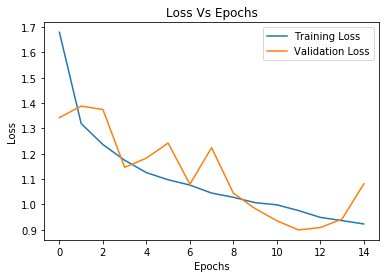

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

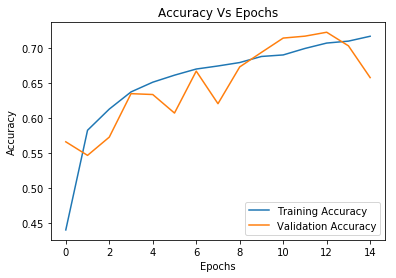

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [37]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=False)
print(f"Test Loss is {test_loss}")
print(f"Test Accuracy is {test_accuracy}")

Test Loss is 1.1963534027649423
Test Accuracy is 0.635295033454895


## 3. CNN neural network classifier
* Build a CNN classifier model using the Sequential API. Your model should use the Conv2D, MaxPool2D, BatchNormalization, Flatten, Dense and Dropout layers. The final layer should again have a 10-way softmax output. 
* You should design and build the model yourself. Feel free to experiment with different CNN architectures. _Hint: to achieve a reasonable accuracy you won't need to use more than 2 or 3 convolutional layers and 2 fully connected layers.)_
* The CNN model should use fewer trainable parameters than your MLP model.
* Compile and train the model (we recommend a maximum of 30 epochs), making use of both training and validation sets during the training run.
* Your model should track at least one appropriate metric, and use at least two callbacks during training, one of which should be a ModelCheckpoint callback.
* You should aim to beat the MLP model performance with fewer parameters!
* Plot the learning curves for loss vs epoch and accuracy vs epoch for both training and validation sets.
* Compute and display the loss and accuracy of the trained model on the test set.

In [14]:
def get_new_CNN_model():
    
    Model = Sequential([
        Conv2D(16, (3,3), padding='same', activation='relu', input_shape=X_train[0].shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(16, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Conv2D(16, (3,3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2,2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    
    return Model

CNN_model = get_new_CNN_model()
CNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 16)        64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2

In [15]:
cp_path = 'CNN_Checkpoint/Best_model'
cp = ModelCheckpoint(cp_path,
                     save_best_only=True,
                     save_weights_only=True,
                     verbose=False,
                     save_freq='epoch',
                     monitor='val_loss',
                     mode='min')

In [16]:
EarlyStop = EarlyStopping(monitor='val_loss', mode='min', patience=3)

In [17]:
CNN_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
history = CNN_model.fit(X_train, y_train, epochs=30, batch_size=64,
                        verbose=1, validation_split=0.1, callbacks=[cp, EarlyStop])

Train on 65931 samples, validate on 7326 samples
Epoch 1/30
65931/65931 [==============================] - 369s 6ms/sample - loss: 0.9891 - accuracy: 0.6716 - val_loss: 0.6092 - val_accuracy: 0.8071
Epoch 2/30
65931/65931 [==============================] - 366s 6ms/sample - loss: 0.5152 - accuracy: 0.8398 - val_loss: 0.5749 - val_accuracy: 0.8163
Epoch 3/30
65931/65931 [==============================] - 365s 6ms/sample - loss: 0.4321 - accuracy: 0.8675 - val_loss: 0.3981 - val_accuracy: 0.8778
Epoch 4/30
65931/65931 [==============================] - 364s 6ms/sample - loss: 0.3828 - accuracy: 0.8824 - val_loss: 0.4350 - val_accuracy: 0.8664
Epoch 5/30
65931/65931 [==============================] - 367s 6ms/sample - loss: 0.3518 - accuracy: 0.8919 - val_loss: 0.3932 - val_accuracy: 0.8793
Epoch 6/30
65931/65931 [==============================] - 365s 6ms/sample - loss: 0.3232 - accuracy: 0.9003 - val_loss: 0.4076 - val_accuracy: 0.8778
Epoch 7/30
65931/65931 [===========================

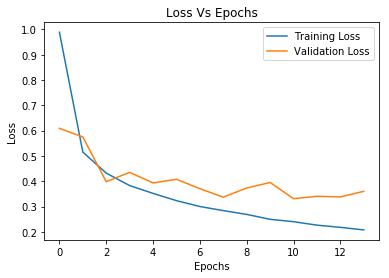

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss Vs Epochs")
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

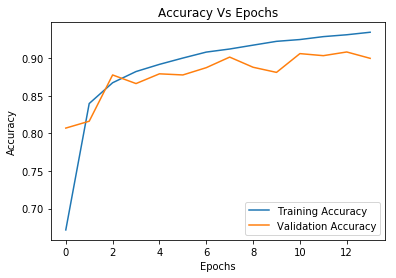

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy Vs Epochs")
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.show()

In [22]:
test_loss, test_accuracy = CNN_model.evaluate(X_test, y_test, verbose=False)
print(f"Test Loss is {test_loss}")
print(f"Test Accuracy is {test_accuracy}")


Test Loss is 0.3953217354144606
Test Accuracy is 0.8936693072319031


## 4. Get model predictions
* Load the best weights for the MLP and CNN models that you saved during the training run.
* Randomly select 5 images and corresponding labels from the test set and display the images with their labels.
* Alongside the image and label, show each model’s predictive distribution as a bar chart, and the final model prediction given by the label with maximum probability.

In [29]:
Best_MLP = get_new_MLP_model()
Best_MLP.load_weights('Checkpoint/Best_model')

In [30]:
Best_CNN = get_new_CNN_model()
Best_CNN.load_weights('CNN_Checkpoint/Best_model')

In [31]:

def show_predictive_distribution(model):

    num_test_images = X_test.shape[0]

    random_inx = np.random.choice(num_test_images, 5)
    random_test_images = X_test[random_inx, ...]
    random_test_labels = y_test[random_inx, ...]

    predictions = model.predict(random_test_images)

    fig, axes = plt.subplots(5, 2, figsize=(16, 12))
    fig.subplots_adjust(hspace=0.4, wspace=-0.2)

    for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
        axes[i, 0].imshow(np.squeeze(image))
        axes[i, 0].get_xaxis().set_visible(False)
        axes[i, 0].get_yaxis().set_visible(False)
        axes[i, 0].text(10., -1.5, f'Digit {label}')
        axes[i, 1].bar(np.arange(len(prediction)), prediction)
        axes[i, 1].set_xticks(np.arange(len(prediction)))
        axes[i, 1].set_title(f"Categorical distribution. Model prediction: {np.argmax(prediction)}")
    
    plt.show()

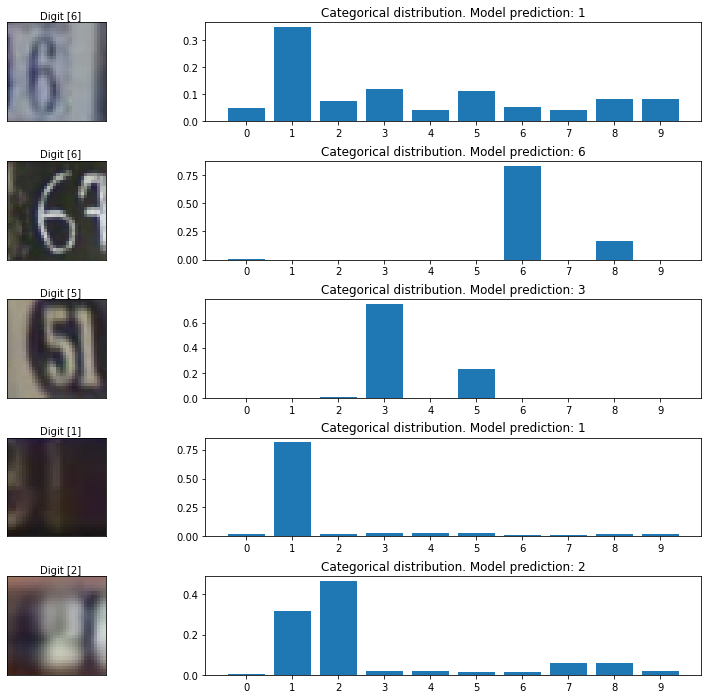

In [32]:
show_predictive_distribution(Best_MLP)

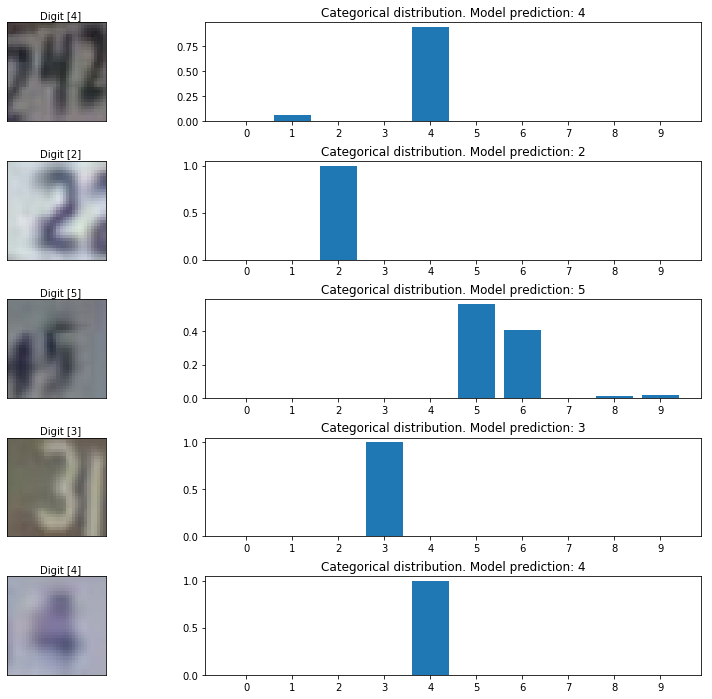

In [33]:
show_predictive_distribution(Best_CNN)